In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from prettytable import PrettyTable
from time import time
import datetime
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from prettytable import PrettyTable
import sklearn
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
import xgboost as xgb
import re
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# reading the datasets
df_train = pd.read_pickle('/content/drive/MyDrive/Self_Case_Study_1/Datasets/feature_engg/fea_eng_train.pkl')
df_test = pd.read_pickle('/content/drive/MyDrive/Self_Case_Study_1/Datasets/feature_engg/fea_eng_test.pkl')

In [4]:
# training and test dataset

X_train = df_train.drop(['isFraud', 'TransactionID', 'uid', 'uid2'], axis=1)
y_train = df_train['isFraud']
X_test = df_test.drop(['TransactionID', 'uid', 'uid2'], axis=1)
test_ids = df_test['TransactionID'].values

In [ ]:
# getting the shape of each train dataset and test dataset
# raw data
print('shape of training dataset:', X_train.shape)
print('shape of test dataset:', X_test.shape)

shape of training dataset: (590538, 236)
shape of test dataset: (506691, 236)


In [ ]:
# available categorical features
cat_fea = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 
           'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
           'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 
           'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
           'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 
           'TransactionHours']

In [ ]:
# normalization using minmaxscaler

def min_max_scaler(X_train, X_test):
    
    X_train_norm = X_train.copy()
    X_test_norm = X_test.copy()
    
    for fea in X_train.columns:
        if fea not in cat_fea:
          if fea not in ['isFraud', 'TransactionID','D4norm', 'D15norm', 'D6norm']:
            scale = MinMaxScaler()
            X_train_norm[fea] = scale.fit_transform(X_train_norm[fea].values.reshape(-1, 1))
            X_test_norm[fea] = scale.transform(X_test_norm[fea].values.reshape(-1, 1))

    return (X_train_norm, X_test_norm)

In [ ]:
# standardizing numerical features

def standard(X_train, X_test):
    
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    
    for fea in X_train.columns:
        if fea not in cat_fea:
          if fea not in ['isFraud', 'TransactionID','D4norm', 'D15norm', 'D6norm']:
            scaler = StandardScaler()
            X_train_std[fea] = scaler.fit_transform(X_train_std[fea].values.reshape(-1, 1))
            X_test_std[fea] = scaler.transform(X_test_std[fea].values.reshape(-1, 1))
    
    return (X_train_std, X_test_std)

In [5]:
# function to save test predictions in a file

def predict_and_save(prediction, name):
    
    '''
        Utility Function to save the test data predictions locally.
    '''

    df = pd.DataFrame({'TransactionID':test_ids.reshape(-1), 'isFraud':prediction.reshape(-1)})
    df = df.sort_values('TransactionID')
    df.to_csv(name, index=False)

In [ ]:
X_train_norm, X_test_norm = min_max_scaler(X_train, X_test) # normalizing the data
X_train_std, X_test_std = standard(X_train, X_test) # standardizing the data

In [ ]:
# fitting the inital model on tuned parameters (cross-validation fit)

idx_tr = X_train.index[:int(X_train.shape[0]*0.75)]  
idx_cv = X_train.index[int(X_train.shape[0]*0.75):]

xgboost_raw = XGBClassifier(
          objective='binary:logistic',
          eval_metric='auc',
          n_estimators=1000,
          tree_method='gpu_hist',
          subsample=0.8,
          max_depth=20,
          colsample_bytree=0.4,
          learning_rate=0.2,
          missing=-1
          )

# fitting the raw data
clf_raw = xgboost_raw.fit(X_train.loc[idx_tr], y_train[idx_tr], eval_set=[(X_train.loc[idx_cv], y_train[idx_cv])], 
            verbose=50, early_stopping_rounds=100)
best_score_raw = roc_auc_score(y_train[idx_cv], xgboost_raw.predict_proba(X_train.loc[idx_cv])[:,1])

[0]	validation_0-auc:0.84405
[50]	validation_0-auc:0.93332
[100]	validation_0-auc:0.93437
[150]	validation_0-auc:0.93529
[200]	validation_0-auc:0.93604
[250]	validation_0-auc:0.93627
[300]	validation_0-auc:0.93586
[323]	validation_0-auc:0.93608


In [ ]:
# fitting the normalized data

xgboost_norm = XGBClassifier(
               objective='binary:logistic',
               eval_metric='auc',
               n_estimators=1000,
               tree_method='gpu_hist',
               subsample=0.8,
               max_depth=20,
               colsample_bytree=0.4,
               learning_rate=0.2,
               missing=-1
               )

clf_norm = xgboost_norm.fit(X_train_norm.loc[idx_tr], y_train[idx_tr], eval_set=[(X_train_norm.loc[idx_cv], y_train[idx_cv])], 
            verbose=50, early_stopping_rounds=100)
best_score_norm = roc_auc_score(y_train[idx_cv], xgboost_norm.predict_proba(X_train_norm.loc[idx_cv])[:,1])

[0]	validation_0-auc:0.84827
[50]	validation_0-auc:0.92788
[100]	validation_0-auc:0.93058
[150]	validation_0-auc:0.93180
[200]	validation_0-auc:0.93225
[250]	validation_0-auc:0.93175
[300]	validation_0-auc:0.93150
[307]	validation_0-auc:0.93131


In [ ]:
# fitting the standardized data

xgboost_std = XGBClassifier(
               objective='binary:logistic',
               eval_metric='auc',
               n_estimators=1000,
               tree_method='gpu_hist',
               subsample=0.8,
               max_depth=20,
               colsample_bytree=0.4,
               learning_rate=0.2,
               missing=-1
               )

clf_std = xgboost_std.fit(X_train_std.loc[idx_tr], y_train[idx_tr], eval_set=[(X_train_std.loc[idx_cv], y_train[idx_cv])], 
            verbose=50, early_stopping_rounds=100)
best_score_std = roc_auc_score(y_train[idx_cv], xgboost_std.predict_proba(X_train_std.loc[idx_cv])[:,1])

[0]	validation_0-auc:0.84827
[50]	validation_0-auc:0.92696
[100]	validation_0-auc:0.92997
[150]	validation_0-auc:0.93143
[200]	validation_0-auc:0.93221
[250]	validation_0-auc:0.93208
[293]	validation_0-auc:0.93161


In [ ]:
# best auc score
print(best_score_raw)
print(best_score_norm)
print(best_score_std)

# raw data gives the best results

0.9366496966345383
0.9322554398403695
0.9323909462897659


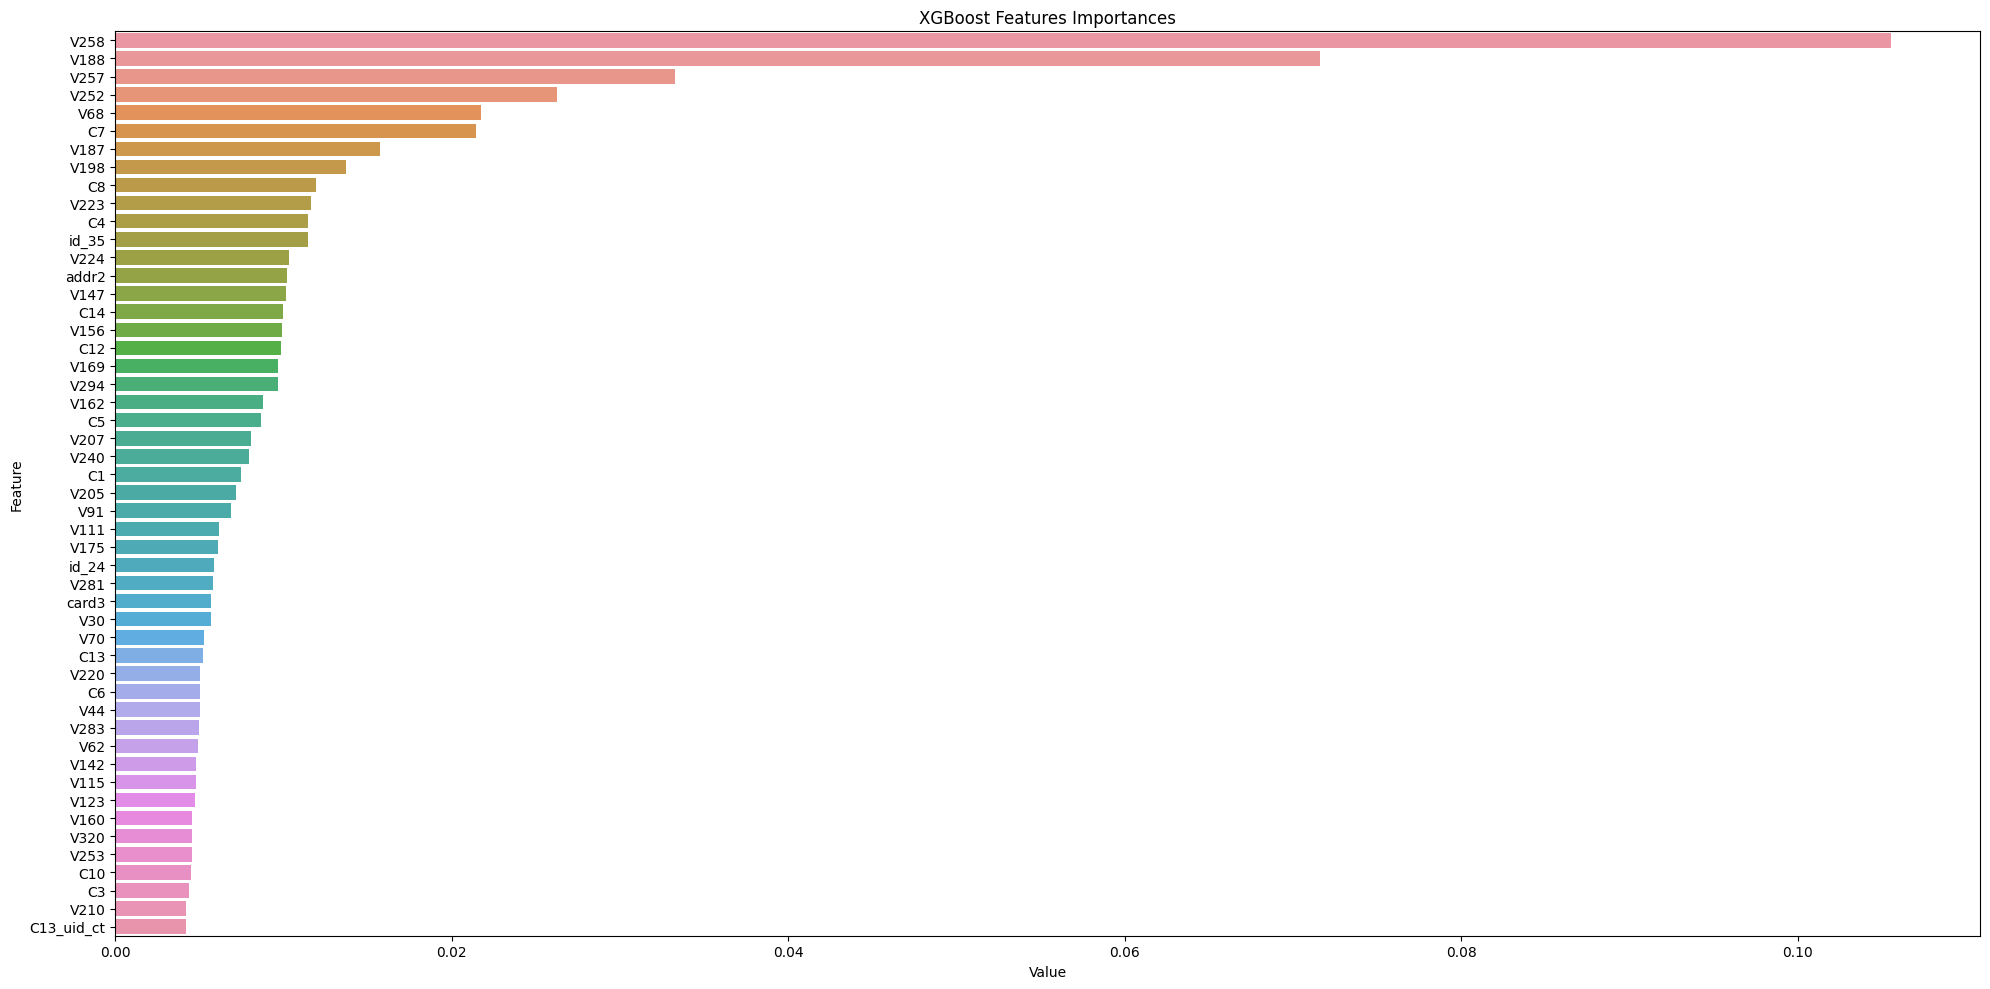

In [ ]:
# feature importances
feature_imp = pd.DataFrame(sorted(zip(clf_raw.feature_importances_, X_train.columns)), columns=['Value','Feature'])

# Top 50 features
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGBoost Features Importances')
plt.tight_layout()
plt.show()

# del xgboost

Area under train roc 1.0
Area under test roc 0.9366496966345383


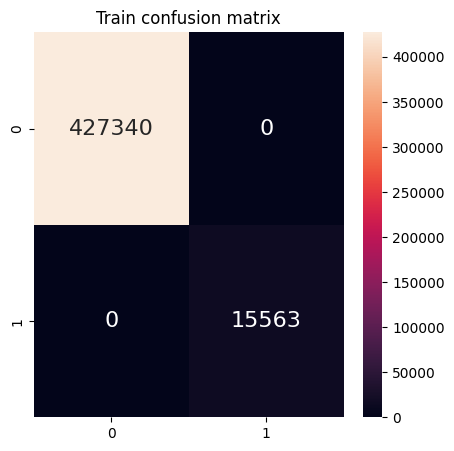

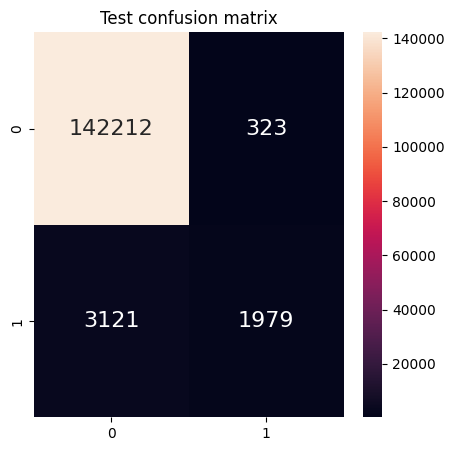

In [ ]:
# AUC and confusion matrix

y_train_pred = clf_raw.predict(X_train.loc[idx_tr])
y_cv_pred = clf_raw.predict(X_train.loc[idx_cv])

train_fpr, train_tpr, thresholds = roc_curve(y_train.loc[idx_tr], clf_raw.predict_proba(X_train.loc[idx_tr])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_train.loc[idx_cv], clf_raw.predict_proba(X_train.loc[idx_cv])[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

train_cf = confusion_matrix(y_train.loc[idx_tr],y_train_pred)
plt.figure(figsize=(5,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()

cv_cf = confusion_matrix(y_train.loc[idx_cv],y_cv_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

del xgboost_raw, xgboost_norm, xgboost_std

In [ ]:
# Setting up the classifier

xgboost = XGBClassifier(
          objective='binary:logistic',
          eval_metric='auc',
          n_estimators=1000,
          tree_method='gpu_hist',
          subsample=0.8,
          max_depth=20,
          colsample_bytree=0.4,
          learning_rate=0.2,
          missing=-1
          )

xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=-1, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Prediction for test data
xgboost_test_proba = xgboost.predict_proba(X_test)[:,1]
predict_and_save(xgboost_test_proba, '/content/drive/MyDrive/Self_Case_Study_1/ipynb/to_predict/xgboost_test_1a.csv')

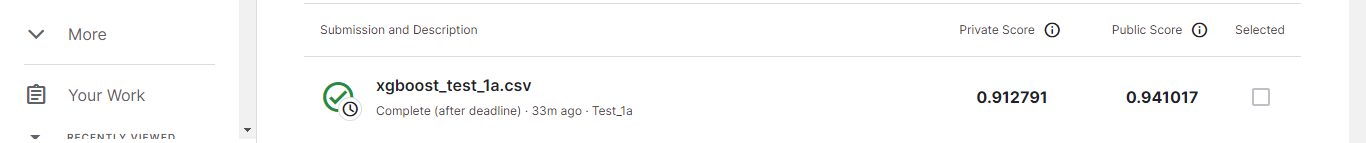

Final Hyperparameter Tuning

In [6]:
clf = xgb.XGBClassifier()

param_grid = {
        'max_depth': [6, 12],
        'learning_rate': [0.002, 0.02, 0.2],
        'subsample': [0.4, 0.8],
        'colsample_bytree': [0.4],
        'n_estimators': [1000, 5000],
        'tree_method':['gpu_hist']}

search = RandomizedSearchCV(clf, param_grid, n_iter=6, verbose=20, cv=3, 
                            scoring='roc_auc', return_train_score=True, random_state = 10)

search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START colsample_bytree=0.4, learning_rate=0.002, max_depth=12, n_estimators=1000, subsample=0.8, tree_method=gpu_hist
[CV 1/3; 1/6] END colsample_bytree=0.4, learning_rate=0.002, max_depth=12, n_estimators=1000, subsample=0.8, tree_method=gpu_hist;, score=(train=0.947, test=0.887) total time= 1.1min
[CV 2/3; 1/6] START colsample_bytree=0.4, learning_rate=0.002, max_depth=12, n_estimators=1000, subsample=0.8, tree_method=gpu_hist
[CV 2/3; 1/6] END colsample_bytree=0.4, learning_rate=0.002, max_depth=12, n_estimators=1000, subsample=0.8, tree_method=gpu_hist;, score=(train=0.940, test=0.913) total time= 1.1min
[CV 3/3; 1/6] START colsample_bytree=0.4, learning_rate=0.002, max_depth=12, n_estimators=1000, subsample=0.8, tree_method=gpu_hist
[CV 3/3; 1/6] END colsample_bytree=0.4, learning_rate=0.002, max_depth=12, n_estimators=1000, subsample=0.8, tree_method=gpu_hist;, score=(train=0.939, test=0.892) total time= 1.

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=6,
                   param_distributions={'colsample_bytree': [0.4],
                                        'learning_rate': [0.002, 0.02, 0.2],
                                        'max_depth': [6, 12],
                                        'n_estimators': [1000, 5000],
                                        'subsample': [0.4, 0.8],
                                        'tree_method': ['gpu_hist']},
                   random_state=10, return_train_score=True, scoring='roc_auc',
                   verbose=20)

In [7]:
results = pd.DataFrame.from_dict(search.cv_results_)
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']

In [8]:
print('Best Parameters:' , search.best_params_)
print('Best Score:' , search.best_score_)

Best Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.8, 'n_estimators': 5000, 'max_depth': 12, 'learning_rate': 0.002, 'colsample_bytree': 0.4}
Best Score: 0.9261822292845769


In [9]:
best_learning_rate = search.best_params_['learning_rate']
best_estimator = search.best_params_['n_estimators']
best_depth = search.best_params_['max_depth']
best_subsample = search.best_params_['subsample']
best_colsample_bytree = search.best_params_['colsample_bytree']

6 fold cross validation

In [19]:
tr_pred = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)
for i, (idx_tr, idx_cv) in enumerate(skf.split(X_train, y_train, groups=X_train['TransactionHours'])):
    print('Fold',i)
    print('rows of train =',len(idx_tr),'rows of holdout =',len(idx_cv))
    clf = xgb.XGBClassifier(
          n_estimators=5000,
          max_depth=12,
          learning_rate=0.002,
          subsample=0.8,
          colsample_bytree=0.4,
          missing=-1,
          eval_metric='auc',
          tree_method='gpu_hist' 
          )

    h = clf.fit(X_train.iloc[idx_tr], y_train.iloc[idx_tr], eval_set=[(X_train.iloc[idx_cv],y_train.iloc[idx_cv])],
                verbose=250, early_stopping_rounds=200)

    tr_pred[idx_cv] += clf.predict_proba(X_train.iloc[idx_cv])[:,1]
    preds += clf.predict_proba(X_test)[:,1]/skf.n_splits

    del h, clf

print('#'*25)
print ('XGB CV=',roc_auc_score(y_train,tr_pred)) #Total Train dataset

Fold 0
rows of train = 490884 rows of holdout = 99654
[0]	validation_0-auc:0.86060
[250]	validation_0-auc:0.90465
[500]	validation_0-auc:0.91227
[750]	validation_0-auc:0.92003
[1000]	validation_0-auc:0.92776
[1250]	validation_0-auc:0.93478
[1500]	validation_0-auc:0.94044
[1750]	validation_0-auc:0.94510
[2000]	validation_0-auc:0.94977
[2250]	validation_0-auc:0.95393
[2500]	validation_0-auc:0.95771
[2750]	validation_0-auc:0.96112
[3000]	validation_0-auc:0.96377
[3250]	validation_0-auc:0.96580
[3500]	validation_0-auc:0.96740
[3750]	validation_0-auc:0.96859
[4000]	validation_0-auc:0.96951
[4250]	validation_0-auc:0.97031
[4500]	validation_0-auc:0.97090
[4750]	validation_0-auc:0.97145
[4999]	validation_0-auc:0.97193
Fold 1
rows of train = 491530 rows of holdout = 99008
[0]	validation_0-auc:0.85882
[250]	validation_0-auc:0.89957
[500]	validation_0-auc:0.90628
[750]	validation_0-auc:0.91356
[1000]	validation_0-auc:0.92056
[1250]	validation_0-auc:0.92725
[1500]	validation_0-auc:0.93318
[1750]	v

Final submission on Kaggle

In [20]:
# Setting up the classifier

fxgboost = XGBClassifier(
          objective='binary:logistic',
          eval_metric='auc',
          n_estimators=5000,
          tree_method='gpu_hist',
          subsample=0.8,
          max_depth=12,
          colsample_bytree=0.4,
          learning_rate=0.002,
          missing=-1
          )

fxgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.002, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=-1, monotone_constraints=None,
              n_estimators=5000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
# Prediction for test data
fxgboost_test_proba = fxgboost.predict_proba(X_test)[:,1]
predict_and_save(fxgboost_test_proba, '/content/drive/MyDrive/Self_Case_Study_1/ipynb/to_predict/xgboost_test_f.csv')

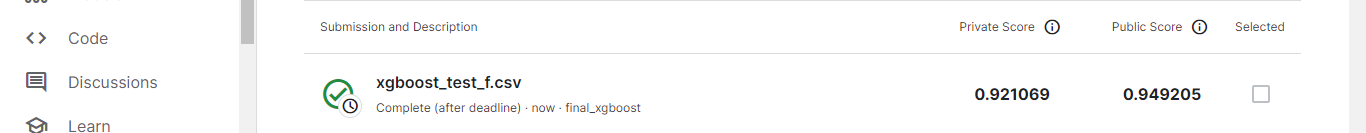

### Final Kaggle Score

Private Score: 0.921069

Public Score: 0.949205